In [1]:
! pip install yfinance

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
import numba
import pandas as pd
import random
from datetime import datetime, timezone, timedelta
from enum import Enum
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt
import pytz
import requests
from DataImportfromYf import DataImportfromYf
from Classes import Frequency, Position, Config, PositionType, Weight, BaseWeightComputation
from model_validation import get_train_val_test_idx_rolling, get_train_val_test_idx_regular
from Features import add_return, binarize_label, standardize_feat_regular, standardize_feat_basket
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Input, BatchNormalization
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import RandomUniform, GlorotUniform, GlorotNormal
from keras.models import load_model, model_from_json
from LSTM_model import LongShortTermMemory
from Backtest_classes import PositionGenerator, Backtester

2023-01-31 16:13:49.409778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 16:13:52.541163: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 16:13:52.946840: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 16:13:52.946957: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Data Loading & Wrangling
Define the universe, the time range and interval considered (2002-05-01 To 2020-01-01).

The constituents taken are the same as the ones defined (constituents of OMXS30 in Feb 2020)

In [3]:
universe = ["GETI-B.ST", "ATCO-A.ST", "VOLV-B.ST", "TEL2-B.ST", "ELUX-B.ST", "TELIA.ST", "HM-B.ST", "SKA-B.ST", 
            "ALFA.ST", "ERIC-B.ST", "SKF-B.ST", "SAND.ST", "AZN.ST", "SECU-B.ST", "INVE-B.ST", "ABB.ST", 
            "SEB-A.ST", "SHB-A.ST", "SCA-B.ST", "SSAB-A.ST", "ASSA-B.ST", "ALIV-SDB.ST", "HEXA-B.ST", 
            "SWED-A.ST", "ATCO-B.ST", "KINV-B.ST", "BOL.ST", "NDA-SE.ST"]
start_date = datetime(2002, 5, 1)
end_date = datetime(2020, 1, 1)
interval = "1d"

obj = DataImportfromYf(universe=universe, start_ts=start_date, end_ts=end_date, interval=interval, ignore_tz=True)
data = obj.get_data()

[*********************100%***********************]  28 of 28 completed


In [4]:
data.head(5)

adj_close       close        high         low  \
ts         symbol                                                        
2002-05-01 ABB.ST        68.324257   73.443237   73.443237   73.443237   
           ALIV-SDB.ST  190.604431  228.500000  228.500000  228.500000   
           ATCO-A.ST      3.608177    7.640396    7.640396    7.640396   
           ATCO-B.ST      3.110863    7.141966    7.141966    7.141966   
           AZN.ST       402.793335  482.000000  482.000000  482.000000   

                              open  volume  
ts         symbol                           
2002-05-01 ABB.ST        73.443237     0.0  
           ALIV-SDB.ST  228.500000     0.0  
           ATCO-A.ST      7.640396     0.0  
           ATCO-B.ST      7.141966     0.0  
           AZN.ST       482.000000     0.0

## Clean the data and add past, future returns and target 

In [5]:
# Are there any missing values ?
data[data.isnull().any(axis=1)]

,,adj_close,close,high,low,open,volume
ts,symbol,,,,,,


In [6]:
# Past Returns
data = add_return(data, target="close", deltas=[1], by="symbol", disable_tqdm=True)
# Future Returns
data = add_return(data, target="close", deltas=[-1], by="symbol", disable_tqdm=True)

In [7]:
# Drop useless data
data = data.dropna(subset=["past_ret_1D_close", "fut_ret_1D_close"])

In [8]:
# Target feature (y label)
label_name = "fut_ret_1D_close"
label_fit = data[label_name]
label_fit = binarize_label(data=label_fit)

/home/ibenchek/projet/projet-ZZ2/LSTM/Features.py:74: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  data = data.groupby("ts").apply(lambda df: pd.Series((df > df.median()).astype(int), index=df.index))


In [9]:
# Standardized the past return with respect to the stock basket at each date
data = standardize_feat_basket(data=data, features_names = ["past_ret_1D_close"], by = ["ts"])

In [10]:
len(data[data.isnull().any(axis=1)])

891

In [11]:
# drop na introduced by the standardization process
data = data.dropna(subset=["past_ret_1D_close", "fut_ret_1D_close"])

# Statistical Learning

## Train and save all LSTM models for each stock

In [12]:
def train_all_lstm(data: pd.DataFrame, label_fit: pd.Series, feature: str, symbol_list: List[str], 
                   strategy_code: str, model_parameters: Dict[str, Any], path_model: str) -> None:
  for symbol in symbol_list:
    lstm = LongShortTermMemory(data, label_fit, feature, symbol, strategy_code, model_parameters, path_model)
    # Split the ts in three different sets (we retrieve only indexes)
    train_idx, val_idx, test_idx = lstm.split_series()
    # return all datasets (x_train,x_val, etc.) in a dict
    res = lstm.get_data(train_idx, val_idx, test_idx)
    # Shape the data as recommanded in the keras api
    shaped_data = lstm.shape_data(res)
    # fit the LSTM
    lstm.fit(shaped_data)
    # Save the model
    lstm.save_lstm_model(path_model)

In [13]:
# config variables
path_model = f"./Models/"
opt = Adam(learning_rate=0.001)
model_parameters = {"split_ratio" : {"train" : 0.70, "val" : 0.15}, "n_steps" : 240,
                    "early_stopp_patience" : 5, "epochs" : 100, "batch_size": 30, "init" : 0, 
                    "n_neurons" : 3, "dropout" : 0.06, "recurrent_dropout" : 0, "metrics" : "accuracy", 
                    "optimizer" : opt, "kernel_init" : GlorotUniform(seed=123),
                    "path_model" : path_model}

In [14]:
train_all_lstm(data, label_fit, "past_ret_1D_close", universe, "my_first_strat", model_parameters, path_model)

2023-01-31 16:15:52.409086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-31 16:15:52.411303: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-31 16:15:52.412203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IsmailBENCHEK): /proc/driver/nvidia/version does not exist
2023-01-31 16:15:52.430474: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
96/96 - 19s - loss: 2.9342 - accuracy: 0.4990 - val_loss: 1.2050 - val_accuracy: 0.5401 - 19s/epoch - 200ms/step
Epoch 2/100
96/96 - 5s - loss: 0.9953 - accuracy: 0.4993 - val_loss: 0.7336 - val_accuracy: 0.4882 - 5s/epoch - 51ms/step
Epoch 3/100
96/96 - 5s - loss: 0.7377 - accuracy: 0.5010 - val_loss: 0.7143 - val_accuracy: 0.4858 - 5s/epoch - 51ms/step
Epoch 4/100
96/96 - 5s - loss: 0.7241 - accuracy: 0.5056 - val_loss: 0.7049 - val_accuracy: 0.4882 - 5s/epoch - 48ms/step
Epoch 5/100
96/96 - 5s - loss: 0.7143 - accuracy: 0.5073 - val_loss: 0.7068 - val_accuracy: 0.4764 - 5s/epoch - 50ms/step
Epoch 6/100
96/96 - 5s - loss: 0.7127 - accuracy: 0.5031 - val_loss: 0.6993 - val_accuracy: 0.4811 - 5s/epoch - 49ms/step
Epoch 7/100
96/96 - 5s - loss: 0.7115 - accuracy: 0.5154 - val_loss: 0.7000 - val_accuracy: 0.4976 - 5s/epoch - 50ms/step
Epoch 8/100
96/96 - 5s - loss: 0.7092 - accuracy: 0.5031 - val_loss: 0.7001 - val_accuracy: 0.4906 - 5s/epoch - 49ms/step
Epoch 9/100
96/96 - 5

## Load all LSTM models for each stock

In [17]:
def load_all_lstm(data: pd.DataFrame, label_fit: pd.Series, feature: str, symbol_list: List[str], 
                   strategy_code: str, model_parameters: Dict[str, Any], path_model: str) -> Dict[str, LongShortTermMemory]:
  res = {}
  for symbol in symbol_list:
    lstm = LongShortTermMemory(data, label_fit, feature, symbol, strategy_code, model_parameters, path_model)
    lstm.load_lstm_model(path_model)
    res[symbol] = lstm
  return res

In [18]:
lstm_dict = load_all_lstm(data, label_fit, "past_ret_1D_close", universe, "my_first_strat", model_parameters, path_model)

Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk
Loaded model from disk


# Backtesting part (once the ML model is trained)

In [19]:
start_ts_backtest = datetime(2015, 7, 5)
end_ts_backtest = datetime(2017, 6, 28)

## 1. Predictions with LSTM models on the backtest period
First, we need to retrieve the predictions of all LSTM on the stocks present in the universe on the trading period. We made the predictions before because the predict method is very time consuming so we can't make prediction quote by quote directly in the backtester.

In [20]:
def predict_from_trained_models(lstm_dict: Dict[str, LongShortTermMemory], data: pd.DataFrame, label: pd.Series,
                                start_date: datetime, end_date: datetime, n_steps: int, feature: str):
  res = {}
  for symbol, lstm in lstm_dict.items():
    # Retrieve relevant data
    series = data[data.index.get_level_values("symbol") == symbol][feature].loc[start_date:end_date]
    # Retrieve the range of prediction dates
    predict_dates = [date[0] for date in series.loc[series.index[n_steps][0]:].index]
    y = label_fit[label_fit.index.get_level_values("symbol") == symbol].loc[start_date:end_date]
    # Create observations composed of sequences
    testX,  testY = LongShortTermMemory.create_samples(series.values, y.values, n_steps)
    testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
    # Predict
    y_pred = lstm.predict(testX)
    tmp = {date:pred[0] for date, pred in zip(predict_dates, y_pred)}
    res[symbol] = tmp
  return res

In [21]:
pred_dict = predict_from_trained_models(lstm_dict=lstm_dict, data=data, label=label_fit, start_date=start_ts_backtest, 
                                        end_date=end_ts_backtest, n_steps=240, feature="past_ret_1D_close")
                                        

9/9 [==============================] - 0s 11ms/step


## 2. Declare and Instanciate useful backtesting objects

### Df to quote list | config | Backtester

In [22]:
quote_list = DataImportfromYf.data_to_quote_list(data)

In [23]:
model_prm = {}
config = Config(universe=universe, strategy_code="my_first_strat", frequency=Frequency.DAILY, 
                model_parameters=model_parameters, quote_list=quote_list, 
                start_ts_backtest=start_ts_backtest, end_ts_backtest=end_ts_backtest)

In [24]:
# We pass to the backtester the predictions made by all LSTM
backtester = Backtester(config=config, quote_list=quote_list, ml_predictions=pred_dict)

## 3. Run the backtest on the trading period

In [25]:
# Run time between 10 and 30s (it depends on the length of the trading period)
perfs = backtester.run_backtest()

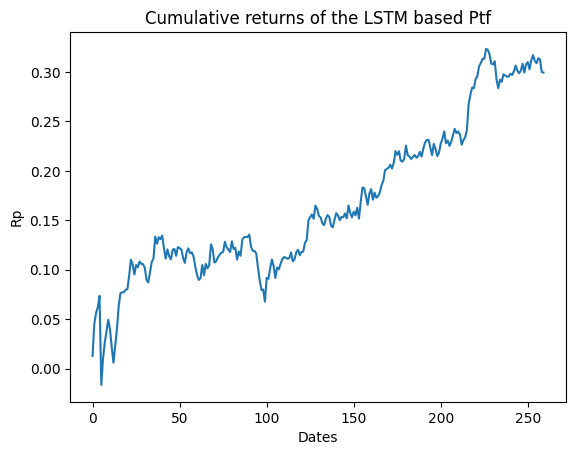

In [26]:
# Cumulative returns
plt.plot(np.cumsum(perfs))
plt.title("Cumulative returns of the LSTM based Ptf")
plt.xlabel("Dates")
plt.ylabel("Rp")
plt.show()

In [27]:
# Compounded return
tmp_ret = [(1 + x) for x in perfs]
compounded_ret = np.cumprod(tmp_ret)

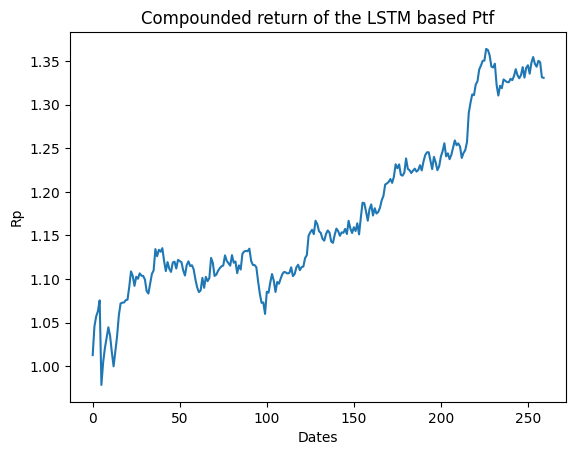

In [28]:
plt.plot(compounded_ret)
plt.title("Compounded return of the LSTM based Ptf")
plt.xlabel("Dates")
plt.ylabel("Rp")
plt.show()